In [1]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from clr_gat import CLRGAT
from dataloaders.dataloaders import UnlabelledDataset, get_episode_loader
from umap import UMAP
from sklearn.manifold import TSNE
import pytorch_lightning as pl
import numpy as np

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
pl.seed_everything(72)

Global seed set to 72


72

In [3]:
sns.set_theme()
sns.set_context("paper")

In [4]:
model = CLRGAT.load_from_checkpoint("7379345_72.1.ckpt").to("cuda")

MultiHeadDotProduct


/home/ojass/anaconda3/envs/ai/lib/python3.9/site-packages/torch/nn/init.py:403: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [5]:
from torchsummary import summary

In [10]:
summary(model.model.backbone, input_data=(3, 84, 84), depth=4)

Layer (type:depth-idx)                   Output Shape              Param #
├─ModuleList: 1                          []                        --
|    └─ConvBlock: 2-1                    [-1, 96, 42, 42]          --
|    |    └─Sequential: 3-1              [-1, 96, 42, 42]          --
|    |    |    └─Conv2d: 4-1             [-1, 96, 84, 84]          2,592
|    |    |    └─BatchNorm2d: 4-2        [-1, 96, 84, 84]          192
|    |    |    └─ReLU: 4-3               [-1, 96, 84, 84]          --
|    |    |    └─MaxPool2d: 4-4          [-1, 96, 42, 42]          --
|    └─ConvBlock: 2-2                    [-1, 128, 21, 21]         --
|    |    └─Sequential: 3-2              [-1, 128, 21, 21]         --
|    |    |    └─Conv2d: 4-5             [-1, 128, 42, 42]         110,592
|    |    |    └─BatchNorm2d: 4-6        [-1, 128, 42, 42]         256
|    |    |    └─ReLU: 4-7               [-1, 128, 42, 42]         --
|    |    |    └─MaxPool2d: 4-8          [-1, 128, 21, 21]         --
|    

Layer (type:depth-idx)                   Output Shape              Param #
├─ModuleList: 1                          []                        --
|    └─ConvBlock: 2-1                    [-1, 96, 42, 42]          --
|    |    └─Sequential: 3-1              [-1, 96, 42, 42]          --
|    |    |    └─Conv2d: 4-1             [-1, 96, 84, 84]          2,592
|    |    |    └─BatchNorm2d: 4-2        [-1, 96, 84, 84]          192
|    |    |    └─ReLU: 4-3               [-1, 96, 84, 84]          --
|    |    |    └─MaxPool2d: 4-4          [-1, 96, 42, 42]          --
|    └─ConvBlock: 2-2                    [-1, 128, 21, 21]         --
|    |    └─Sequential: 3-2              [-1, 128, 21, 21]         --
|    |    |    └─Conv2d: 4-5             [-1, 128, 42, 42]         110,592
|    |    |    └─BatchNorm2d: 4-6        [-1, 128, 42, 42]         256
|    |    |    └─ReLU: 4-7               [-1, 128, 42, 42]         --
|    |    |    └─MaxPool2d: 4-8          [-1, 128, 21, 21]         --
|    

## Train Data

In [6]:
ds = UnlabelledDataset("miniimagenet", "/home/ojass/projects/unsupervised-meta-learning/data/untarred/", split="train", n_support=1, n_query=3, no_aug_support=True, img_size_orig=[84, 84])

In [7]:
from torch.utils.data import DataLoader

In [8]:
dl = DataLoader(ds, shuffle=True, num_workers=1, batch_size=64)

In [9]:
idl = iter(dl)

In [10]:
xs = next(idl)

In [11]:
s, q, l = xs["origs"], xs["views"], xs["labels"]

In [12]:
s_labels = l[:, 0]

In [13]:
x = torch.cat([s, q], dim=1)

In [14]:
import einops

In [15]:
x.shape

torch.Size([64, 4, 3, 84, 84])

In [16]:
x = einops.rearrange(x, 'b q c h w -> (b q) c h w')

In [17]:
model = model.to("cuda")

In [70]:
z_cnn, z = model.mpnn_forward(x.to("cuda"))

In [19]:
r = UMAP().fit_transform(z.cpu().detach().numpy())

In [20]:
import pandas as pd

In [21]:
c1, c2 = l.flatten().unique(return_counts=True)
df = pd.DataFrame({"label": c1, "count": c2})
df.head()

,label,count
0,0,8
1,1,4
2,2,4
3,3,4
4,4,4


In [22]:
df[df["count"] > 4]

,label,count
0,0,8
5,6,12
6,8,8
8,12,8
9,16,8
12,19,8
14,22,8
16,24,8
18,26,8
21,33,8


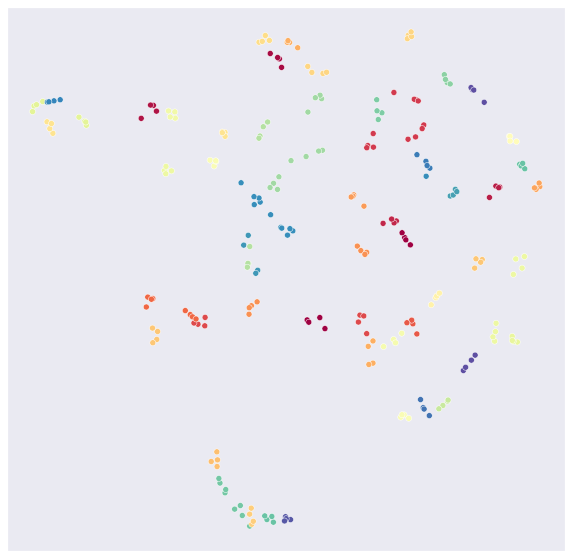

In [27]:
fig, ax = plt.subplots(figsize=(10,10))
ax.grid(False)
gnn_plot = sns.scatterplot(x=r[:, 0], y=r[:, 1], hue=l.flatten().cpu().numpy(), palette="Spectral", legend=None, ax=ax)
gnn_plot.set(xticklabels=[], yticklabels=[]);

In [71]:
r_cnn = TSNE().fit_transform(z_cnn.flatten(1).cpu().detach().numpy())

/home/ojass/anaconda3/envs/ai/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ojass/anaconda3/envs/ai/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[None, None]

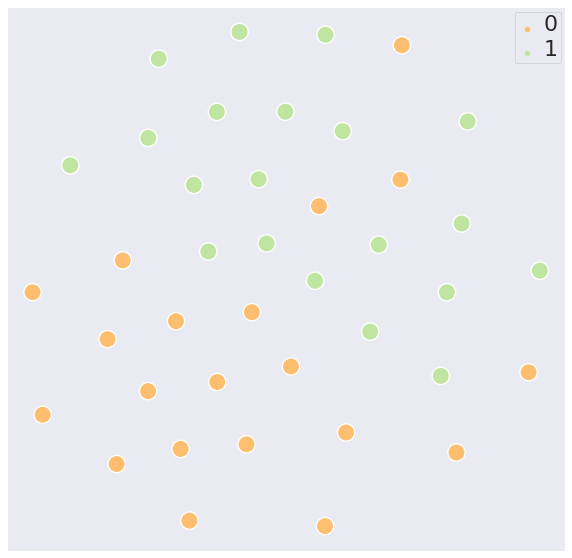

In [92]:
fig, ax = plt.subplots(figsize=(10,10))
ax.grid(False)
cnn_plot = sns.scatterplot(x=r_cnn[:, 0], y=r_cnn[:, 1], hue=tru_y.flatten().cpu().numpy(), palette="Spectral", legend="full", ax=ax, s=300)
cnn_plot.set(xticklabels=[], yticklabels=[]);
plt.setp(ax.get_legend().get_texts(), fontsize='22') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='32')

In [32]:
r_cnn = TSNE().fit_transform(z_cnn.flatten(1).cpu().detach().numpy())

/home/ojass/anaconda3/envs/ai/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ojass/anaconda3/envs/ai/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


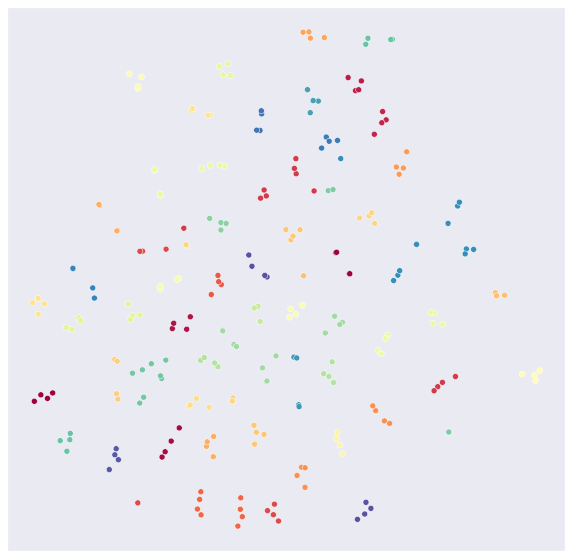

In [34]:
fig, ax = plt.subplots(figsize=(10,10))
ax.grid(False)
cnn_plot = sns.scatterplot(x=r_cnn[:, 0], y=r_cnn[:, 1], hue=l.flatten().cpu().numpy(), palette="Spectral", legend=None, ax=ax)
cnn_plot.set(xticklabels=[], yticklabels=[]);

In [93]:
cnn_plot.get_figure().savefig("cnn_val_emb.pdf")

In [73]:
r = TSNE().fit_transform(z.cpu().detach().numpy())

/home/ojass/anaconda3/envs/ai/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ojass/anaconda3/envs/ai/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


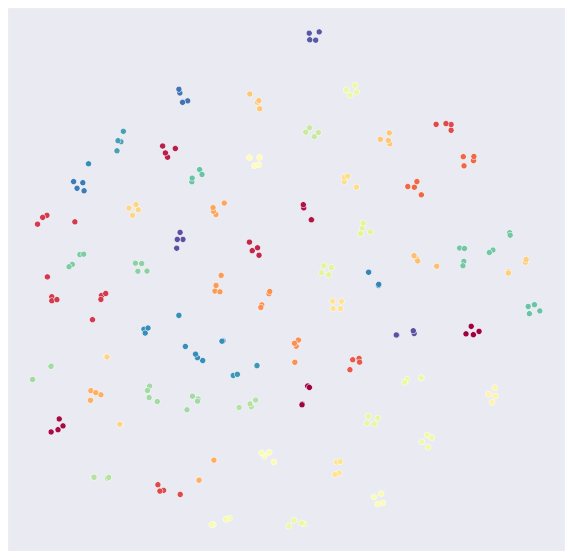

In [39]:
fig, ax = plt.subplots(figsize=(10,10))
ax.grid(False)
gnn_plot = sns.scatterplot(x=r[:, 0], y=r[:, 1], hue=l.flatten().cpu().numpy(), palette="Spectral", legend=None, ax=ax)
gnn_plot.set(xticklabels=[], yticklabels=[]);

In [74]:
r = TSNE().fit_transform(z.cpu().detach().numpy())

/home/ojass/anaconda3/envs/ai/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ojass/anaconda3/envs/ai/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[None, None]

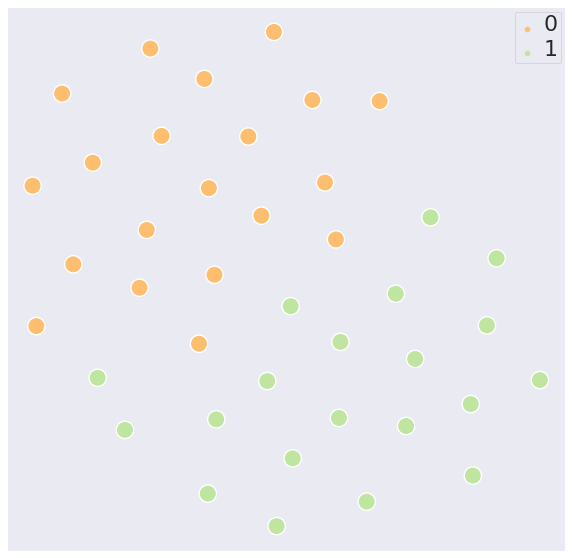

In [94]:
fig, ax = plt.subplots(figsize=(10,10))
ax.grid(False)
gnn_plot = sns.scatterplot(x=r[:, 0], y=r[:, 1], hue=tru_y.flatten().cpu().numpy(), palette="Spectral", legend="full", ax=ax, s=300)
gnn_plot.set(xticklabels=[], yticklabels=[]);
plt.setp(ax.get_legend().get_texts(), fontsize='22') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='32')

In [95]:
gnn_plot.get_figure().savefig("gnn_val_emb.pdf")

## Testing episdic data

In [96]:
sns.set_context("paper")
# sns.set_style("dark")
plt.style.use('ggplot')

In [97]:
from optimal_transport.optimal_transport import OptimalTransport

In [98]:
k = 2
dl = get_episode_loader("miniimagenet", "/home/ojass/projects/unsupervised-meta-learning/data/untarred/", ways=k, shots=5, test_shots=15, batch_size=1, split="val")

Supervised data loader for miniimagenet:val.


In [99]:
idl = iter(dl)

In [100]:
for _ in range(5):
    xs = next(idl)

In [101]:
train = xs["train"]
test = xs["test"]

In [102]:
x_train = train[0][0]

In [103]:
y_train = train[1][0]

In [104]:
y_train

tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

In [105]:
x_test = test[0][0]
y_test = test[1][0]

In [106]:
x = torch.cat([x_train, x_test])

In [107]:
x = torch.load("good_data2.dat")

In [144]:
torch.cuda.empty_cache()

In [145]:
z_o = model(x.to("cuda"))

In [146]:
tru_y = torch.cat([y_train, y_test])

In [147]:
r_o = UMAP(n_neighbors=20, min_dist=0.1).fit_transform(z_o.cpu().detach().numpy())

In [148]:
s = [150] * y_train.shape[-1] + [80] * y_test.shape[-1]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


[None, None]

<Figure size 1080x1080 with 0 Axes>

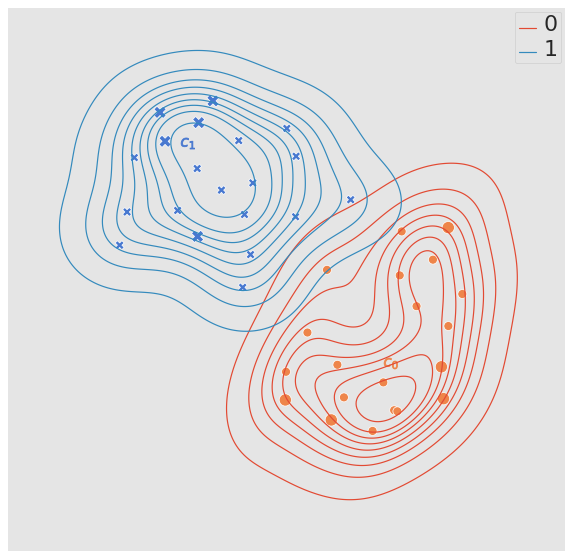

In [149]:
# sns.set(rc={'figure.figsize':(10,10)})
sns.set_context("paper")
sns.despine(left=True, bottom=True)
fig, ax = plt.subplots(figsize=(10,10))
ax.grid(False)
palette = sns.color_palette("muted", k)[::-1]
plot1 = sns.scatterplot(x=r_o[:, 0], y=r_o[:, 1], hue=tru_y.cpu().numpy(), palette=palette, legend="auto", style=tru_y.cpu().numpy(), s=s, ax=ax)
plot1.set(xticklabels=[], yticklabels=[])
protos1 = np.split(r_o, ([10, 30]))[0].reshape(k, -1, 2).mean(1)
# sns.scatterplot(x=protos1[:, 0], y=protos1[:, 1], hue=[1, 2, 0], palette=palette, legend="auto", markers=["h", "h", "h"], s=200)
for i, p in enumerate(protos1):
    plt.scatter(x=p[0], y=p[1], c=palette[i], s=200, marker=f'$c_{i}$')
sns.kdeplot(x=r_o[:, 0], y=r_o[:, 1], hue=tru_y.cpu().numpy().tolist())
plt.setp(ax.get_legend().get_texts(), fontsize='22') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='32')

In [150]:
from sklearn.metrics import davies_bouldin_score as dbs

In [151]:
dbs(r_o, tru_y)

0.6681042021196434

In [152]:
fig1 = plot1.get_figure()

In [153]:
plot1.get_figure().savefig("raw_emb.pdf")

In [158]:
r_o = TSNE(perplexity=15).fit_transform(z_o.cpu().detach().numpy())

/home/ojass/anaconda3/envs/ai/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ojass/anaconda3/envs/ai/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


[None, None]

<Figure size 1080x1080 with 0 Axes>

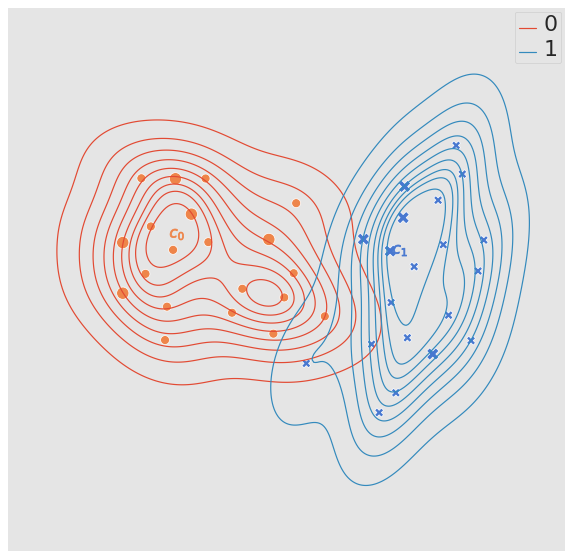

In [159]:
# sns.set(rc={'figure.figsize':(10,10)})
sns.set_context("paper")
sns.despine(left=True, bottom=True)
fig, ax = plt.subplots(figsize=(10,10))
ax.grid(False)
palette = sns.color_palette("muted", k)[::-1]
plot1 = sns.scatterplot(x=r_o[:, 0], y=r_o[:, 1], hue=tru_y.cpu().numpy(), palette=palette, legend="auto", style=tru_y.cpu().numpy(), s=s, ax=ax)
plot1.set(xticklabels=[], yticklabels=[])
protos1 = np.split(r_o, ([10, 30]))[0].reshape(k, -1, 2).mean(1)
# sns.scatterplot(x=protos1[:, 0], y=protos1[:, 1], hue=[1, 2, 0], palette=palette, legend="auto", markers=["h", "h", "h"], s=200)
for i, p in enumerate(protos1):
    plt.scatter(x=p[0], y=p[1], c=palette[i], s=200, marker=f'$c_{i}$')
sns.kdeplot(x=r_o[:, 0], y=r_o[:, 1], hue=tru_y.cpu().numpy().tolist())
plt.setp(ax.get_legend().get_texts(), fontsize='22') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='32')

In [160]:
transportation_module = OptimalTransport(regularization=0.05, learn_regularization=False, max_iter=1000,
                                                     stopping_criterion=1e-4, device="cuda")

In [161]:
z_supp, z_query = z_o.split([10, 30])

In [162]:
z_supp, z_query = transportation_module(z_supp, z_query)

In [163]:
z = torch.cat([z_supp, z_query])

In [164]:
r = UMAP(n_neighbors=20, min_dist=0.25).fit_transform(z.cpu().detach().numpy())

In [165]:
tru_y = torch.cat([y_train, y_test])
s = [150] * y_train.shape[-1] + [80] * y_test.shape[-1]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


[None, None]

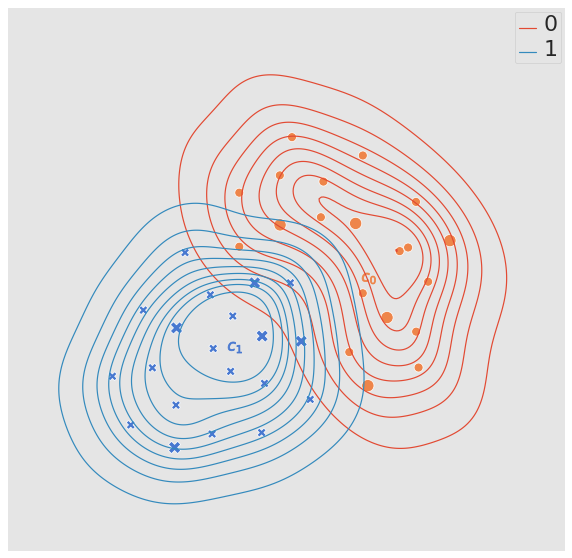

In [166]:
sns.set_context("paper")
palette = sns.color_palette("muted", k)[::-1]
fig, ax = plt.subplots(figsize=(10,10))
ax.grid(False)
plot2 = sns.scatterplot(x=r[:, 0], y=r[:, 1], hue=tru_y.cpu().numpy(), palette=palette, legend="auto", style=tru_y.cpu().numpy(), s=s, ax=ax)
plot2.set(xticklabels=[], yticklabels=[])
protos2 = np.split(r, ([10, 30]))[0].reshape(k, -1, 2).mean(1)
for i, p in enumerate(protos2):
    plt.scatter(x=p[0], y=p[1], c=palette[i], s=200, marker=f'$c_{i}$')
# sns.scatterplot(x=protos2[:, 0], y=protos2[:, 1], hue=[1, 2, 0], palette=palette, legend="auto", markers=["h", "h", "h"], s=200)
sns.kdeplot(x=r[:, 0], y=r[:, 1], hue=tru_y.cpu().numpy().tolist())
plt.setp(ax.get_legend().get_texts(), fontsize='22') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='32')

In [167]:
dbs(r, tru_y)

0.8939193491688106

In [168]:
plot2.get_figure().savefig("ot.pdf")

In [295]:
torch.save(x, "good_data3.dat")

# GradCAM stuff

In [506]:
k = 2
dl = get_episode_loader("miniimagenet", "/home/ojass/projects/unsupervised-meta-learning/data/untarred/", ways=k, shots=1, test_shots=15, batch_size=1, split="val")

Supervised data loader for miniimagenet:val.


In [507]:
idl = iter(dl)

In [508]:
for _ in range(10):
    xs = next(idl)

train = xs["train"]
test = xs["test"]

x_train = train[0][0]
y_train = train[1][0]

x_test = test[0][0]
y_test = test[1][0]

In [35]:
from PIL import Image
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam import GradCAM

In [36]:
class SimilarityToConcept:
    def __init__(self, features):
        self.features = features
    def __call__(self, model_output):
        print("here")
        cos = torch.nn.CosineSimilarity(dim=0)
        return cos(model_output, self.features)

In [37]:
target_layers = [model.model.backbone._feature_blocks[-2]]

In [49]:
from torchvision.utils import make_grid, save_image
from torchvision import transforms

In [126]:
def show_image(img:torch.Tensor):
    plt.imshow(img.permute(1, 2, 0), interpolation="bilinear")

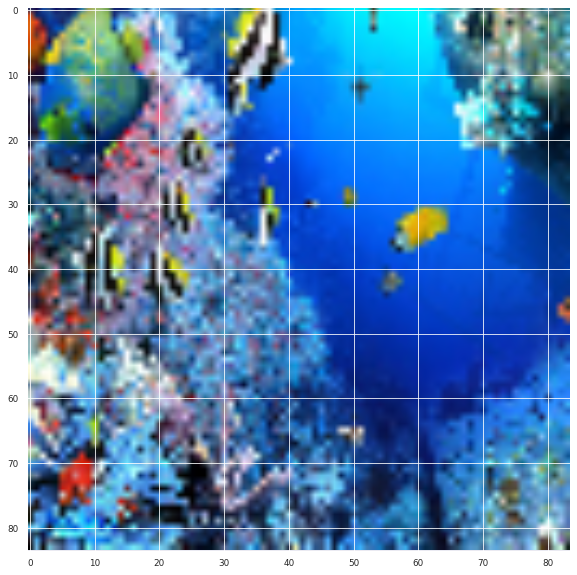

In [510]:
show_image(x_train[0])

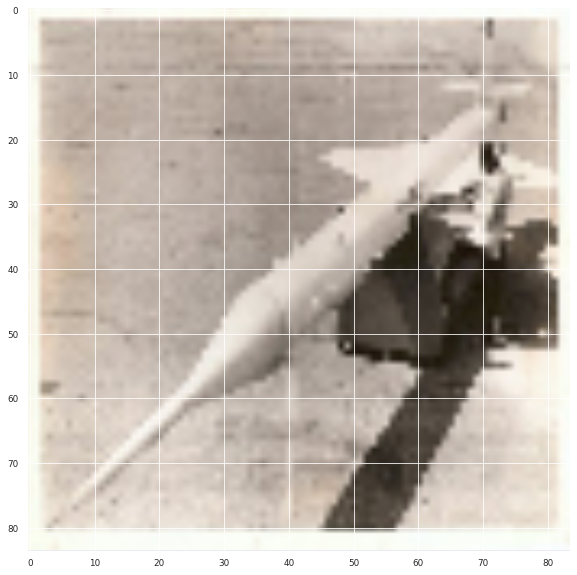

In [511]:
show_image(x_train[1])

In [47]:
def save_pil_image(x, name):
    transforms.ToPILImage()(x).resize((224, 224)).save(f"{name}.png")
    return 1

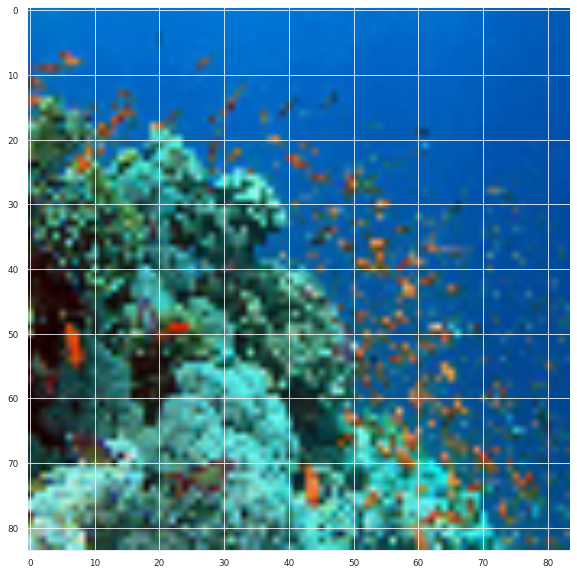

In [513]:
show_image(x_test[13])

In [516]:
concept_features, _ = model.mpnn_forward(x_train.to("cuda"))

In [517]:
concept1_features = concept_features[0]

In [518]:
concept2_features = concept_features[1]

In [447]:
with torch.enable_grad():
    concept1_features = concept1_features.mean(0)
    concept2_features = concept2_features.mean(0)

In [519]:
concept1_target = [SimilarityToConcept(concept1_features)]
concept2_target = [SimilarityToConcept(concept2_features)]

In [571]:
def grad_cam_and_save(input_img, concept_target, model=model.model.backbone, target_layers=target_layers, save_name=None, reshape_transform=None):
    with GradCAM(model=model, target_layers=target_layers, use_cuda=True, reshape_transform=reshape_transform) as cam:
        cam_gray_scale = cam(input_tensor=input_img.unsqueeze(0), targets=concept_target)[0, :]
    cam_image = show_cam_on_image(input_img.permute(1, 2, 0).numpy(), cam_gray_scale, use_rgb=True)
    if save_name is not None:
        save_pil_image(input_img, save_name)
        Image.fromarray(cam_image).resize([224, 224]).save(f"{save_name}_cam.png")
    return cam_image

In [526]:
cam_image = grad_cam_and_save(x_test[13], concept1_target)

here


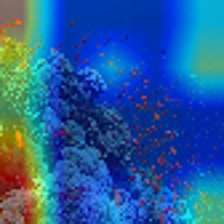

In [527]:
Image.fromarray(cam_image).resize([224, 224])

In [411]:
save_pil_image(x_train[3], "swan1")

1

In [315]:
save_pil_image(x_test[13], "white_wolf_test_2")

1

In [412]:
img1.save("swan1_cam.png")

In [544]:
cam_image2 = grad_cam_and_save(x_test[21], concept2_target)

here


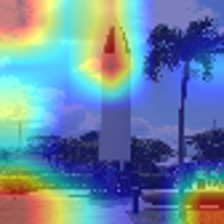

In [545]:
cam_image2 = Image.fromarray(cam_image2).resize([224, 224])
cam_image2

In [532]:
save_pil_image(x_train[1], "rocket")

1

In [534]:
save_pil_image(x_test[16], "rocket_test1")

1

In [535]:
cam_image2.save("rocket_test_cam.png")

In [583]:
_, concept_features= model.mpnn_forward(x_train.to("cuda"))

In [584]:
import einops

In [585]:
with torch.enable_grad():
    concept_features = einops.rearrange(concept_features, "b d -> b d 1 1")

In [586]:
concept1_features = concept_features[0]

concept2_features = concept_features[1]

In [587]:
def reshape_transform_gat(tensor, h, w):
    with torch.enable_grad():
        tensor = einops.rearrange(tensor, "b d -> b d 1 1")
    return tensor

In [588]:
concept1_target = [SimilarityToConcept(concept1_features)]
concept2_target = [SimilarityToConcept(concept2_features)]

In [589]:
target_layers=[model.model.gnn.bottleneck]

In [590]:
grad_cam_and_save(x_test[21], concept2_target, model=model.model, target_layers=target_layers, reshape_transform=reshape_transform_gat)

here


RuntimeError: grad can be implicitly created only for scalar outputs